In [1]:
#change directory
import os
os.chdir('/Users/kaixianglim/Documents/DSS5104/Group_Project/5-min_frequency_data/FINAL')

import numpy as np 
import pylab as plt
import pandas as pd
import sklearn
from scipy.stats import zscore
import xgboost as xgb

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

import time
from memory_profiler import memory_usage


## ENERGY PRICE DATA

In [2]:
# load file 'Energy_Data/df_with_lag_indicators.csv.gz' into a pandas dataframe
df = pd.read_csv('Energy_Data/df_with_lag_indicators.csv.gz', compression='gzip')


In [3]:
#df header
df.head()

timestamp  Energy_Demand  Energy_Price  Crude_Oil_Price  \
0  3/1/22 0:00        7294.03      4.370966            78.25   
1  3/1/22 0:05        7304.76      4.507557            78.25   
2  3/1/22 0:10        7176.53      4.476996            78.25   
3  3/1/22 0:15        7247.72      4.497028            78.25   
4  3/1/22 0:20        7169.96      4.478132            78.25   

   Natural_Gas_Price  Rainfall  Carbon_Intensity  Renewable_Energy_Percentage  \
0               3.74       0.0            313.43                        58.81   
1               3.74       0.0            313.43                        58.81   
2               3.74       0.0            313.43                        58.81   
3               3.74       0.0            313.43                        58.81   
4               3.74       0.0            313.43                        58.81   

   Temperature  Solar_Exposure  hour  dayofweek  month     lag_1  lag_12  \
0           22               0     0          0      1       NaN     NaN   
1           22               0     0          0      1  4.370966     NaN   
2           22               0     0          0      1  4.507557     NaN   
3           22               0     0          0      1  4.476996     NaN   
4           22               0     0          0      1  4.497028     NaN   

   lag_288  lag_576  rolling_mean_24  rolling_std_24  
0      NaN      NaN              NaN             NaN  
1      NaN      NaN              NaN             NaN  
2      NaN      NaN              NaN             NaN  
3      NaN      NaN              NaN             NaN  
4      NaN      NaN              NaN             NaN

In [4]:
df_target = 'Energy_Price'
df_predictors = [col for col in df.columns if col != df_target]

In [5]:
#set timestamp as index
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df.set_index('timestamp', inplace=True)

Text(0.5, 1.0, 'Energy_Price against time')

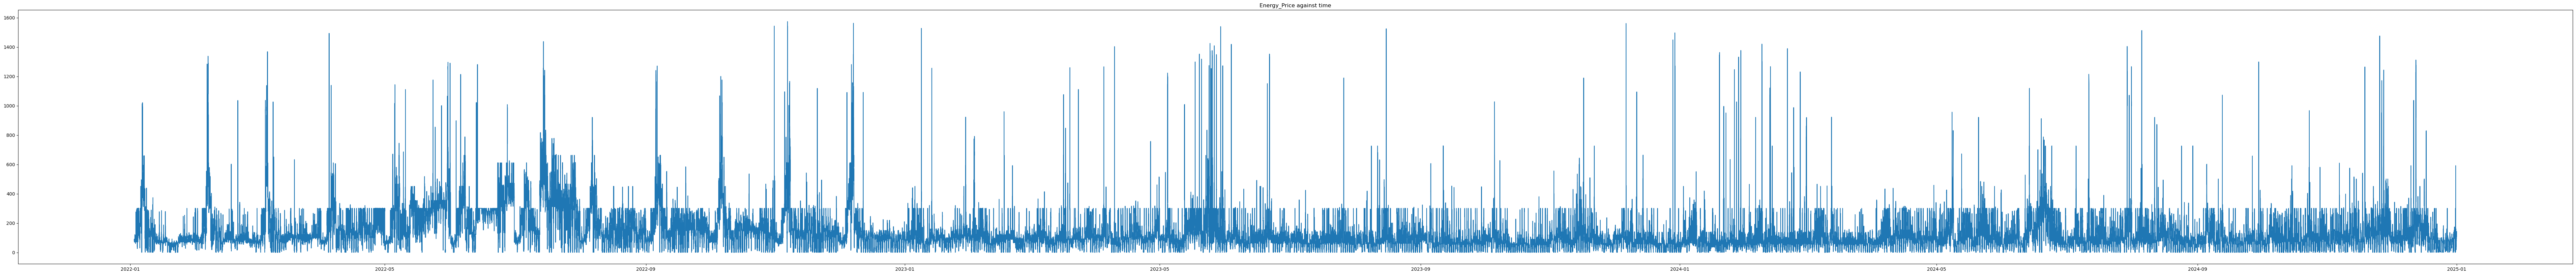

In [6]:
#plot df_target against index
plt.figure(figsize=(100, 10))
plt.plot(df.index, np.exp(df[df_target]), label=df_target)
plt.title(f"{df_target} against time")


Text(0.5, 1.0, 'Energy_Price distribution')

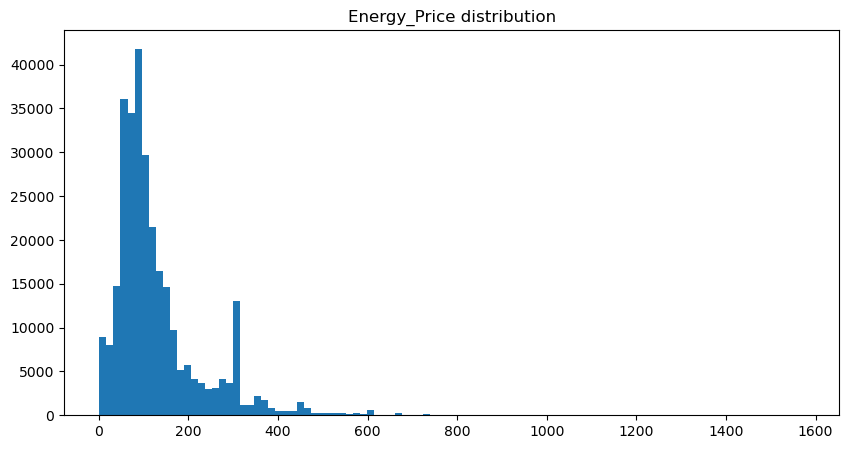

In [7]:
#plot df_target distribution
plt.figure(figsize=(10, 5))
plt.hist(np.exp(df[df_target]), bins=100)
plt.title(f"{df_target} distribution")



In [8]:
def walk_forward_validation(df, lags, horizon=1, initial_train_size=100):
    predictions = []
    actuals = []
    
    for t in range(initial_train_size, len(df) - horizon):
        train = df.iloc[:timestamp]
        test = df.iloc[timestamp:timestamp + horizon]

        X_train = train.drop(columns=["energy_price"])
        y_train = train["energy_price"]
        X_test = test.drop(columns=["energy_price"])
        y_test = test["energy_price"]

        model = XGBRegressor()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        predictions.extend(y_pred)
        actuals.extend(y_test.values)

In [9]:
# 1. Prepare the Data

#all other columns are predictors
y = df[df_target]
X = df.drop(columns=[df_target])

# 2. Split the Data into Training and Testing Sets
# It's crucial to split time series data chronologically to avoid data leakage
train_size = int(len(df) * 0.8)  # Use 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 3. Define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 4. Create XGB Regressor
xgb_base = xgb.XGBRegressor(random_state=42)

# Setup Randomized Search
xgbm = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,              # Number of parameter sets to try
    scoring='neg_root_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error', etc.
    cv=5,                   # Cross-validation folds
    verbose=1,
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

xgbm.fit(X_train, y_train)

# Function to wrap training process
def train_model():
    xgbm.fit(X_train, y_train)  
    return xgbm

# Measure time and memory
start_time = time.time()
mem_usage, model = memory_usage((train_model,), retval=True, max_usage=True)
end_time = time.time()

print(f"Time usage: {end_time - start_time:.3f} seconds")
print(f"Peak memory usage: {mem_usage:.3f} MB")

#print the best parameters
print("Best parameters found: ", xgbm.best_params_)

# Use the best trained model
model = xgbm.best_estimator_

# Merge X and y for easier indexing
df_full = X.copy()
df_full['target'] = y

predictions = []
actuals = []
horizon = 1  # One-step-ahead forecasting

for t in range(train_size, len(df_full) - horizon + 1):
    # Predict on the next time step
    X_test_t = df_full.drop(columns='target').iloc[t:t+horizon]
    y_test_t = df_full['target'].iloc[t:t+horizon]

    y_pred = model.predict(X_test_t)

    predictions.extend(y_pred)
    actuals.extend(y_test_t.values)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Time usage: 89.332 seconds
Peak memory usage: 507.859 MB
Best parameters found:  {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


In [10]:
actuals_original = np.exp(actuals)
predictions_original = np.exp(predictions)

# Basic metrics
mse = mean_squared_error(actuals_original, predictions_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals_original, predictions_original)
r2 = r2_score(actuals_original, predictions_original)

# Adjusted R^2 (adjusted for number of features in X)
n = len(actuals_original)
k = X_test.shape[1]  # Number of predictors
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

# MAPE
mape = np.mean(np.abs((actuals_original - predictions_original) / (actuals_original+1e-10))) * 100

# Print metrics
print(f"\nModel Evaluation (Walk-Forward Forecast):")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Adjusted R^2 Score: {adj_r2:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.4f}%")


Model Evaluation (Walk-Forward Forecast):
Mean Absolute Error: 18.4285
Mean Squared Error: 1596.2224
Root Mean Squared Error: 39.9528
R^2 Score: 0.7868
Adjusted R^2 Score: 0.7868
Mean Absolute Percentage Error: 44.1570%


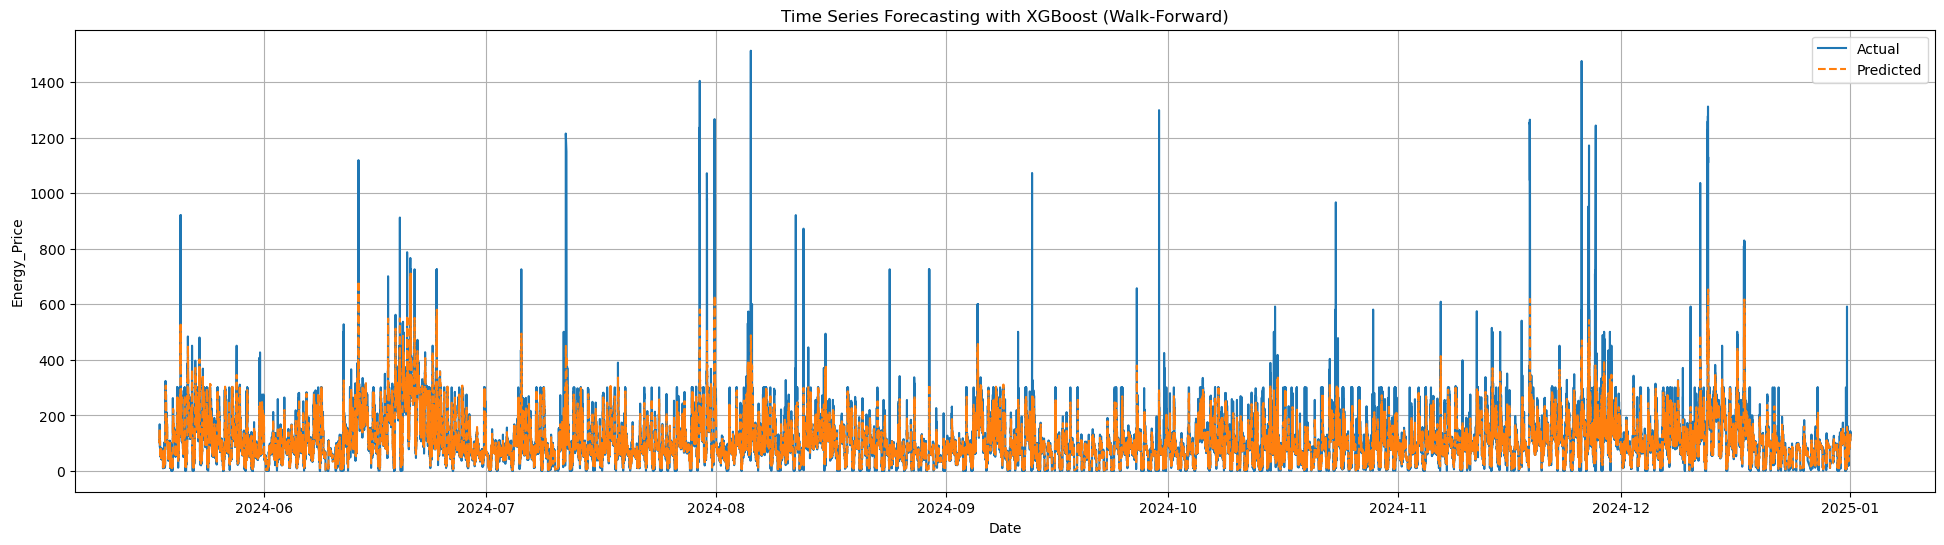

In [11]:
# Extract corresponding index for the walk-forward predictions
forecast_index = df.index[train_size:train_size + len(predictions)]

# Plot actual vs predicted
plt.figure(figsize=(24, 6))
plt.plot(forecast_index, actuals_original, label='Actual')
plt.plot(forecast_index, predictions_original, label='Predicted', linestyle='--')
plt.title('Time Series Forecasting with XGBoost (Walk-Forward)')
plt.xlabel('Date')
plt.ylabel(df_target)
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# 8. Feature importance
best_model = xgbm.best_estimator_
importances = best_model.feature_importances_

for feature, importance in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

lag_1: 0.4319
rolling_mean_24: 0.3256
lag_288: 0.0542
lag_12: 0.0386
Energy_Demand: 0.0306
rolling_std_24: 0.0283
hour: 0.0206
lag_576: 0.0137
Crude_Oil_Price: 0.0114
Solar_Exposure: 0.0079
Temperature: 0.0074
Natural_Gas_Price: 0.0071
Carbon_Intensity: 0.0065
Renewable_Energy_Percentage: 0.0050
month: 0.0042
dayofweek: 0.0036
Rainfall: 0.0034


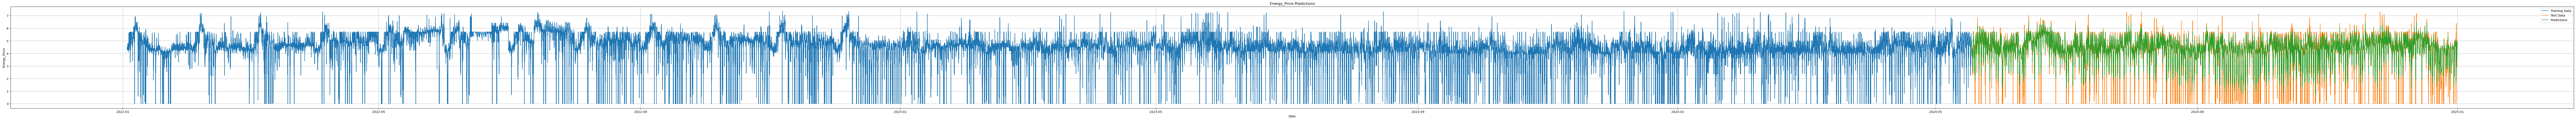

In [29]:
# 9. Plot the training data, test data and predictions on test set
plt.figure(figsize=(150, 6))
plt.plot(df.index[:train_size], y_train, label='Training Data')
plt.plot(df.index[train_size:], y_test, label='Test Data')
plt.plot(df.index[train_size:], predictions, label='Predictions')
plt.title(f"{df_target} Predictions")
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

## FINANCE DATA

In [13]:
# load file 'Finance_Data/processed_finance_data.csv' into a pandas dataframe
df = pd.read_csv('Finance_Data/processed_finance_data.csv')

In [14]:
#df header
df.head()

Date  Close_TSLA  Volume_TSLA  TSLA_Returns  TSLA_day  TSLA_month  \
0  2014-09-17   17.425333   77665500.0      0.002454      17.0         9.0   
1  2014-09-18   17.587999   55389000.0      0.009335      18.0         9.0   
2  2014-09-19   17.288000  102163500.0     -0.017057      19.0         9.0   
3  2014-09-22   16.668667  123211500.0     -0.035824      22.0         9.0   
4  2014-09-23   16.694000   84880500.0      0.001520      23.0         9.0   

   TSLA_weekday   day_sin   day_cos  month_sin  ...  Close_SOXX  Volume_SOXX  \
0           2.0 -0.299363 -0.954139       -1.0  ...   26.093210     444000.0   
1           3.0 -0.485302 -0.874347       -1.0  ...   26.492056     355500.0   
2           4.0 -0.651372 -0.758758       -1.0  ...   26.161163     339000.0   
3           0.0 -0.968077 -0.250653       -1.0  ...   25.845039     315600.0   
4           1.0 -0.998717 -0.050649       -1.0  ...   25.762320     632700.0   

   SOXX_Returns  PCE_Price_Index  Core_PCE_Price_Index  \
0      0.007184           97.413                96.013   
1      0.015285           97.413                96.013   
2     -0.012490           97.413                96.013   
3     -0.012084           97.413                96.013   
4     -0.003201           97.413                96.013   

   10-Year_Treasury_Yield  Federal_Funds_Rate  \
0                    2.62                0.09   
1                    2.63                0.09   
2                    2.59                0.09   
3                    2.57                0.09   
4                    2.54                0.09   

   University_of_Michigan-Consumer_Sentiment  \
0                                       84.6   
1                                       84.6   
2                                       84.6   
3                                       84.6   
4                                       84.6   

   Consumer_Price_Index-All_Items-Total_for_United_States  Total_Vehicle_Sales  
0                                           0.075257                    16.959  
1                                           0.075257                    16.959  
2                                           0.075257                    16.959  
3                                           0.075257                    16.959  
4                                           0.075257                    16.959  

[5 rows x 84 columns]

In [15]:
df_target = 'Close_TSLA'
df_predictors = [col for col in df.columns if col != df_target]

In [16]:
#set timestamp as index
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)

Text(0.5, 1.0, 'Close_TSLA against time')

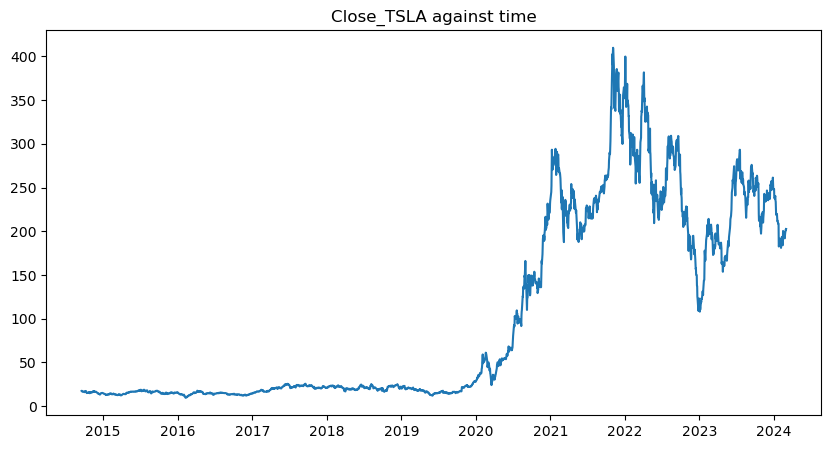

In [31]:
#plot df_target against index
plt.figure(figsize=(10, 5))
plt.plot(df.index, df[df_target], label=df_target)
plt.title(f"{df_target} against time")


Text(0.5, 1.0, 'Close_TSLA distribution')

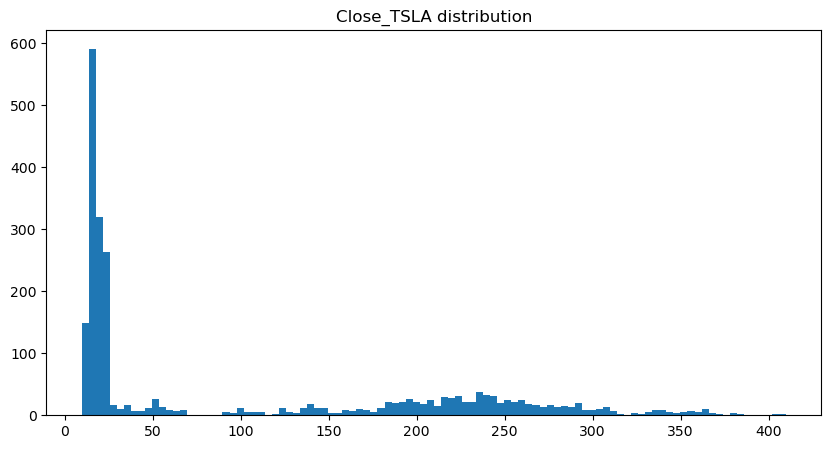

In [32]:
#plot df_target distribution
plt.figure(figsize=(10, 5))
plt.hist(df[df_target], bins=100)
plt.title(f"{df_target} distribution")

In [17]:
# 1. Prepare the Data

#all other columns are predictors
y = df[df_target]
X = df.drop(columns=[df_target])

# 2. Split the Data into Training and Testing Sets
# It's crucial to split time series data chronologically to avoid data leakage
train_size = int(len(df) * 0.8)  # Use 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 3. Define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 4. Create XGB Regressor
xgb_base = xgb.XGBRegressor(random_state=42)

# Setup Randomized Search
xgbm = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,              # Number of parameter sets to try
    scoring='neg_root_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error', etc.
    cv=5,                   # Cross-validation folds
    verbose=1,
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

xgbm.fit(X_train, y_train)

# Function to wrap training process
def train_model():
    xgbm.fit(X_train, y_train)  
    return xgbm

# Measure time and memory
start_time = time.time()
mem_usage, model = memory_usage((train_model,), retval=True, max_usage=True)
end_time = time.time()

print(f"Time usage: {end_time - start_time:.3f} seconds")
print(f"Peak memory usage: {mem_usage:.3f} MB")

#print the best parameters
print("Best parameters found: ", xgbm.best_params_)

# Use the best trained model
model = xgbm.best_estimator_

# Merge X and y for easier indexing
df_full = X.copy()
df_full['target'] = y

predictions = []
actuals = []
horizon = 1  # One-step-ahead forecasting

for t in range(train_size, len(df_full) - horizon + 1):
    # Predict on the next time step
    X_test_t = df_full.drop(columns='target').iloc[t:t+horizon]
    y_test_t = df_full['target'].iloc[t:t+horizon]

    y_pred = model.predict(X_test_t)

    predictions.extend(y_pred)
    actuals.extend(y_test_t.values)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Time usage: 29.064 seconds
Peak memory usage: 412.891 MB
Best parameters found:  {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.6}


In [19]:
actuals = np.array(actuals)
predictions = np.array(predictions)

# 6. Evaluate the Model
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
adj_r2 = 1 - (1 - r2) * (len(actuals) - 1) / (len(actuals) - X_test.shape[1] - 1)
mape = np.mean(np.abs((actuals - predictions) / (actuals +1e-10))) * 100

print(f"Mean Absolute Error on the Test Set: {mae:.4f}")
print(f"Mean Squared Error on the Test Set: {mse:.4f}")
print(f"Root Mean Squared Error on the Test Set: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Adjusted R^2 Score: {adj_r2:.4f}")
print(f"Mean Absolute Percentage Error on the Test Set: {mape:.4f}%")

Mean Absolute Error on the Test Set: 6.9729
Mean Squared Error on the Test Set: 106.3427
Root Mean Squared Error on the Test Set: 10.3123
R^2 Score: 0.9519
Adjusted R^2 Score: 0.9418
Mean Absolute Percentage Error on the Test Set: 3.7625%


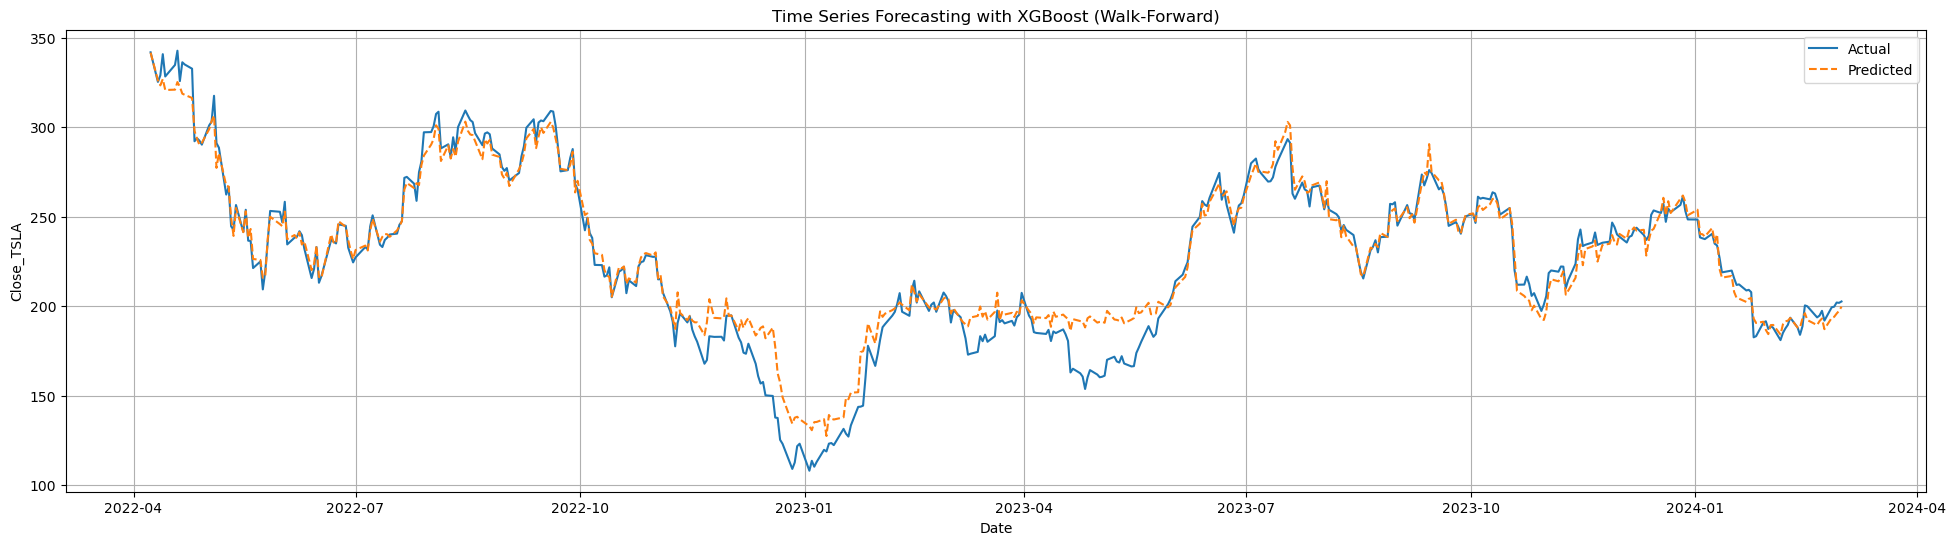

In [21]:
# Extract corresponding index for the walk-forward predictions
forecast_index = df.index[train_size:train_size + len(predictions)]

# Plot actual vs predicted
plt.figure(figsize=(24, 6))
plt.plot(forecast_index, actuals, label='Actual')
plt.plot(forecast_index, predictions, label='Predicted', linestyle='--')
plt.title('Time Series Forecasting with XGBoost (Walk-Forward)')
plt.xlabel('Date')
plt.ylabel(df_target)
plt.legend()
plt.grid(True)
plt.show()

In [39]:
# 8. Feature importance
best_model = xgbm.best_estimator_
importances = best_model.feature_importances_

for feature, importance in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

Close_%5EGSPC: 0.3278
Close_LIT: 0.3144
Close_TSLA_Lag_5: 0.1179
Close_TSLA_Lag_1: 0.1158
TSLA_Ichimoku_Base_Line: 0.0279
Close_TSLA_Lag_30: 0.0167
TSLA_EMA_20: 0.0127
TSLA_Ichimoku_Conversion_Line: 0.0124
Close_TSLA_Lag_3: 0.0071
Close_BZ=F: 0.0060
TSLA_Total_Return_252d: 0.0058
TSLA_BB_High: 0.0054
PCE_Price_Index: 0.0054
TSLA_Open_SMA_10: 0.0049
TSLA_EMA_40: 0.0035
Close_TSLA_Lag_120: 0.0030
Close_TSLA_Lag_4: 0.0024
TSLA_Open_EMA_10: 0.0020
TSLA_SMA_200: 0.0014
TSLA_VWAP_Open: 0.0011
month_sin: 0.0011
Close_TSLA_Lag_2: 0.0009
TSLA_Total_Return_120d: 0.0008
Close_TSLA_Lag_20: 0.0008
Close_SOXX: 0.0005
TSLA_Total_Return_90d: 0.0005
TSLA_month: 0.0003
Close_TSLA_Lag_10: 0.0002
TSLA_Total_Return_10d: 0.0002
Close_BTC-USD: 0.0001
TSLA_Ichimoku_Leading_Span_A: 0.0001
TSLA_Daily_Return: 0.0001
Close_TSLA_Lag_90: 0.0001
TSLA_Returns: 0.0001
TSLA_Ichimoku_Lagging_Span: 0.0001
TSLA_Open_Return: 0.0001
TSLA_Total_Return_5d: 0.0000
TSLA_RSI: 0.0000
TSLA_SMA_100: 0.0000
TSLA_SMA_150: 0.0000
TSLA

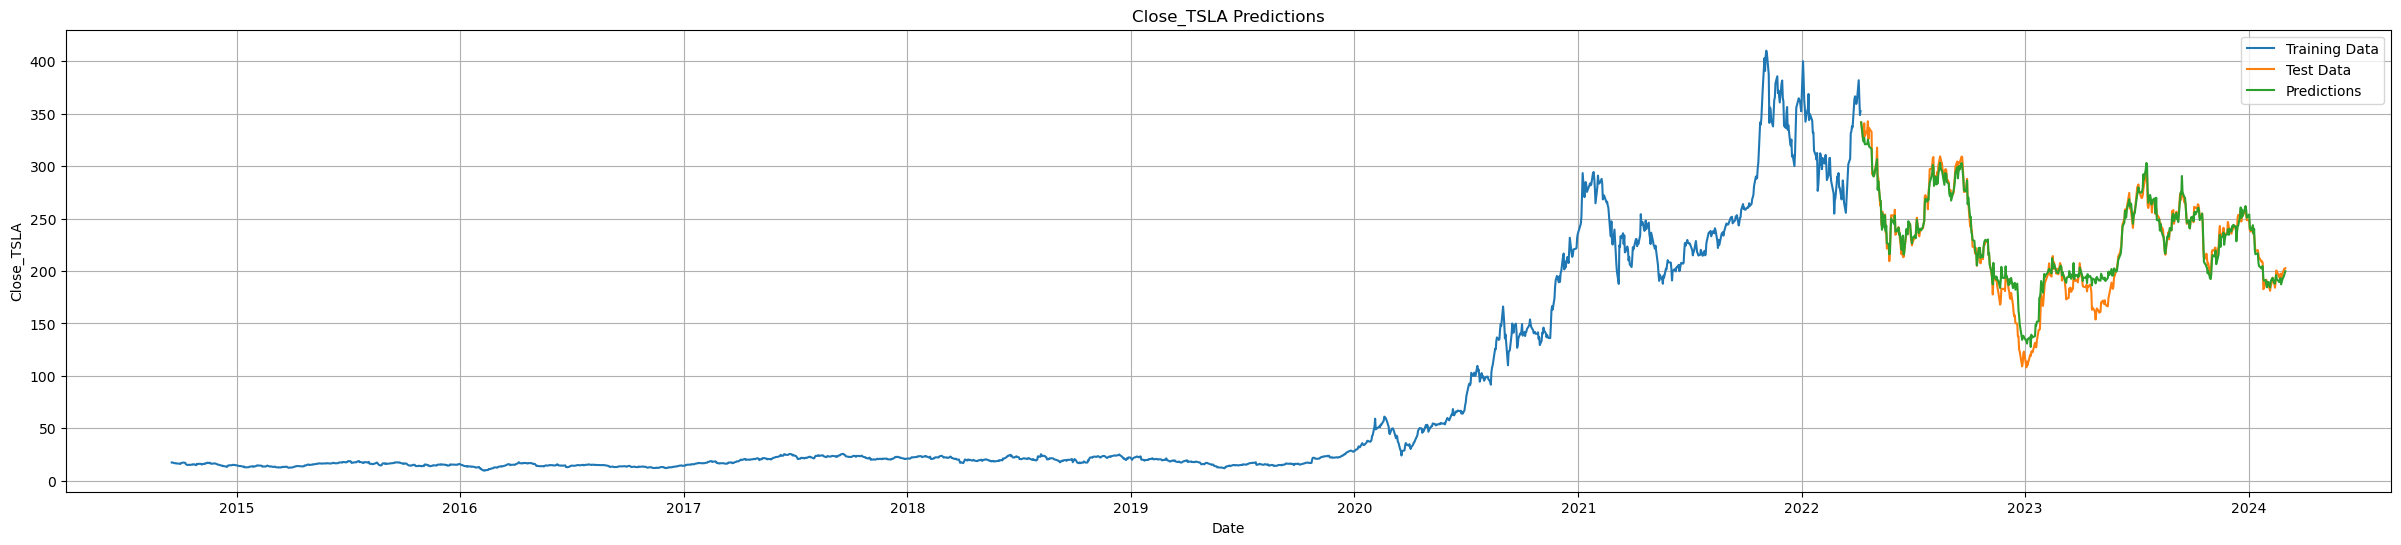

In [40]:
# 9. Plot the training data, test data and predictions on test set
plt.figure(figsize=(30, 6))
plt.plot(df.index[:train_size], y_train, label='Training Data')
plt.plot(df.index[train_size:], y_test, label='Test Data')
plt.plot(df.index[train_size:], predictions, label='Predictions')
plt.title(f"{df_target} Predictions")
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

## CLIMATE DATA

In [22]:
# load file 'Climate_Data/Temperature-Data-with-Lag-Features-of-California.csv into a pandas dataframe
df = pd.read_csv('Climate_Data/Temperature-Data-with-Lag-Features-of-California.csv')


In [23]:
#df header
df.head()

TIME  Mean_Temperature      lag_1  lag_12
0  1/1/81          0.152648        NaN     NaN
1  1/2/81          2.161510   0.152648     NaN
2  1/3/81          5.807921   2.161510     NaN
3  1/4/81         12.537520   5.807921     NaN
4  1/5/81         14.826269  12.537520     NaN

In [24]:
df_target = 'Mean_Temperature'
df_predictors = [col for col in df.columns if col != df_target]

In [25]:
#set timestamp as index
df['TIME'] = pd.to_datetime(df['TIME'], format='%d/%m/%y')
df.set_index('TIME', inplace=True)

Text(0.5, 1.0, 'Mean_Temperature against time')

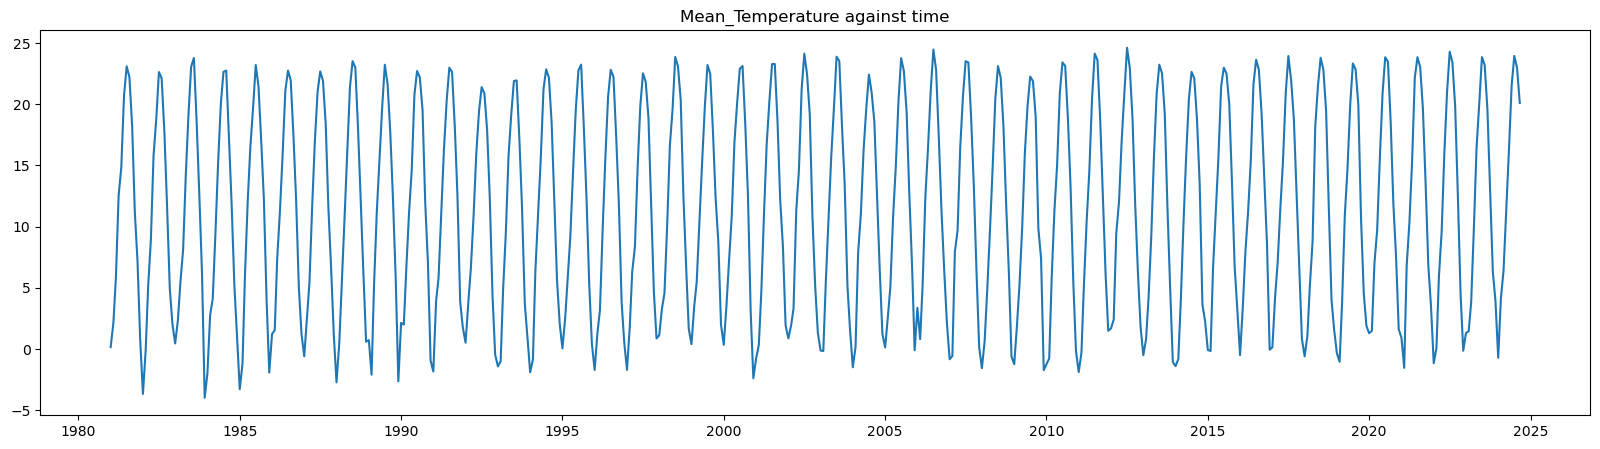

In [26]:
#plot df_target against index
plt.figure(figsize=(20, 5))
plt.plot(df.index, df[df_target], label=df_target)
plt.title(f"{df_target} against time")

Text(0.5, 1.0, 'Mean_Temperature distribution')

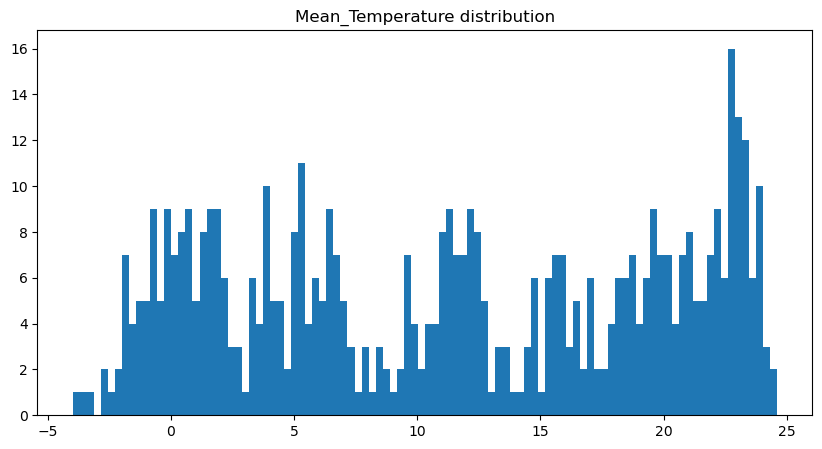

In [39]:
#plot df_target distribution
plt.figure(figsize=(10, 5))
plt.hist(df[df_target], bins=100)
plt.title(f"{df_target} distribution")

In [27]:
# 1. Prepare the Data

#all other columns are predictors
y = df[df_target]
X = df.drop(columns=[df_target])

# 2. Split the Data into Training and Testing Sets
# It's crucial to split time series data chronologically to avoid data leakage
train_size = int(len(df) * 0.8)  # Use 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 3. Define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 4. Create XGB Regressor
xgb_base = xgb.XGBRegressor(random_state=42)

# Setup Randomized Search
xgbm = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,              # Number of parameter sets to try
    scoring='neg_root_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error', etc.
    cv=5,                   # Cross-validation folds
    verbose=1,
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

xgbm.fit(X_train, y_train)

# Function to wrap training process
def train_model():
    xgbm.fit(X_train, y_train)  
    return xgbm

# Measure time and memory
start_time = time.time()
mem_usage, model = memory_usage((train_model,), retval=True, max_usage=True)
end_time = time.time()

print(f"Time usage: {end_time - start_time:.3f} seconds")
print(f"Peak memory usage: {mem_usage:.3f} MB")

#print the best parameters
print("Best parameters found: ", xgbm.best_params_)

# Use the best trained model
model = xgbm.best_estimator_

# Merge X and y for easier indexing
df_full = X.copy()
df_full['target'] = y

predictions = []
actuals = []
horizon = 1  # One-step-ahead forecasting

for t in range(train_size, len(df_full) - horizon + 1):
    # Predict on the next time step
    X_test_t = df_full.drop(columns='target').iloc[t:t+horizon]
    y_test_t = df_full['target'].iloc[t:t+horizon]

    y_pred = model.predict(X_test_t)

    predictions.extend(y_pred)
    actuals.extend(y_test_t.values)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Time usage: 1.989 seconds
Peak memory usage: 460.969 MB
Best parameters found:  {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [28]:
actuals = np.array(actuals)
predictions = np.array(predictions)

# 6. Evaluate the Model
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
adj_r2 = 1 - (1 - r2) * (len(actuals) - 1) / (len(actuals) - X_test.shape[1] - 1)
mape = np.mean(np.abs((actuals - predictions) / (actuals +1e-10))) * 100

print(f"Mean Absolute Error on the Test Set: {mae:.4f}")
print(f"Mean Squared Error on the Test Set: {mse:.4f}")
print(f"Root Mean Squared Error on the Test Set: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Adjusted R^2 Score: {adj_r2:.4f}")
print(f"Mean Absolute Percentage Error on the Test Set: {mape:.4f}%")

Mean Absolute Error on the Test Set: 1.1736
Mean Squared Error on the Test Set: 2.4354
Root Mean Squared Error on the Test Set: 1.5606
R^2 Score: 0.9664
Adjusted R^2 Score: 0.9657
Mean Absolute Percentage Error on the Test Set: 139.4450%


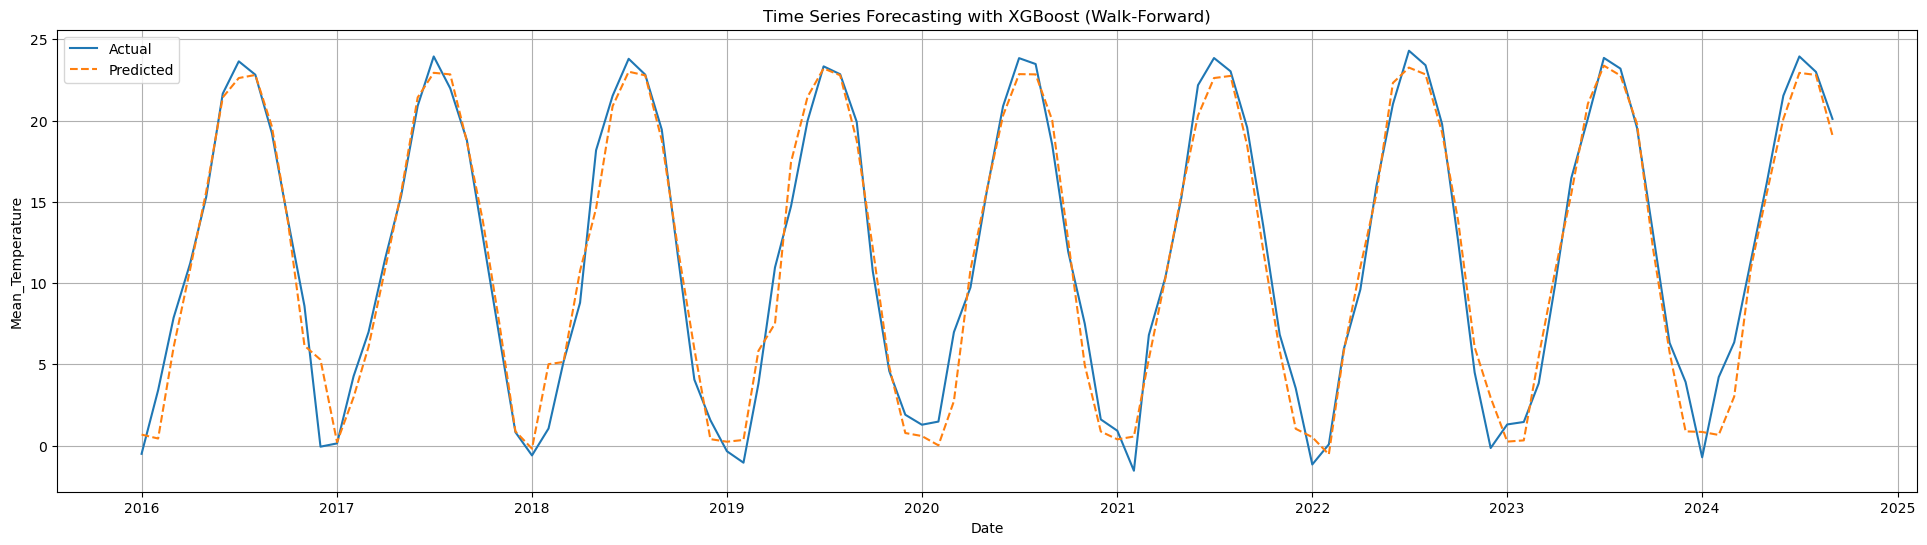

In [29]:
# Extract corresponding index for the walk-forward predictions
forecast_index = df.index[train_size:train_size + len(predictions)]

# Plot actual vs predicted
plt.figure(figsize=(24, 6))
plt.plot(forecast_index, actuals, label='Actual')
plt.plot(forecast_index, predictions, label='Predicted', linestyle='--')
plt.title('Time Series Forecasting with XGBoost (Walk-Forward)')
plt.xlabel('Date')
plt.ylabel(df_target)
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# 8. Feature importance
best_model = xgbm.best_estimator_
importances = best_model.feature_importances_

for feature, importance in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

lag_12: 0.9600
lag_1: 0.0400


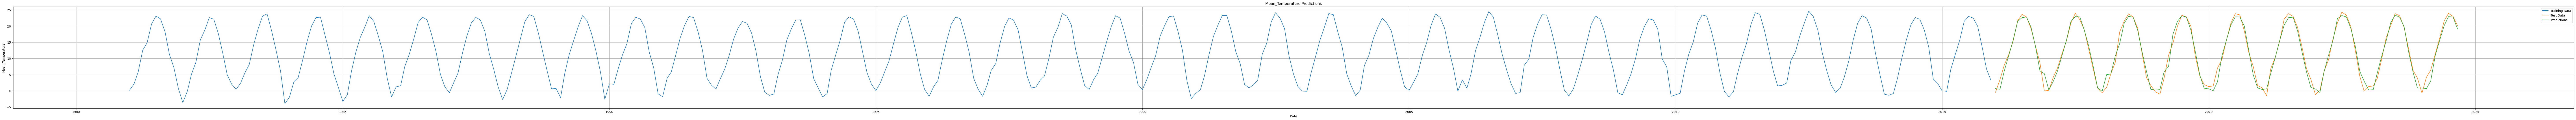

In [51]:
# 9. Plot the training data, test data and predictions on test set
plt.figure(figsize=(150, 6))
plt.plot(df.index[:train_size], y_train, label='Training Data')
plt.plot(df.index[train_size:], y_test, label='Test Data')
plt.plot(df.index[train_size:], predictions, label='Predictions')
plt.title(f"{df_target} Predictions")
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

## RETAIL DATA

In [30]:
# load file 'Retail_Data/data_with_lags_s1_i1.parquet' into a pandas dataframe
df = pd.read_parquet('Retail_Data/data_with_lags_s1_i1.parquet')


In [5]:
#df header
df.head()

date  sales  year  month  day  dayofweek  dayofyear  weekofyear  \
0 2014-01-01      9  2014      1    1          2          1           1   
1 2014-01-02     14  2014      1    2          3          2           1   
2 2014-01-03     11  2014      1    3          4          3           1   
3 2014-01-04     20  2014      1    4          5          4           1   
4 2014-01-05     17  2014      1    5          6          5           1   

   quarter  is_month_start  ...  sales_roll_std_60d  sales_roll_median_60d  \
0        1               1  ...            5.645732                   16.0   
1        1               0  ...            5.628820                   16.0   
2        1               0  ...            5.640326                   16.0   
3        1               0  ...            5.640326                   16.0   
4        1               0  ...            5.643856                   16.0   

   sales_roll_min_60d  sales_roll_max_60d  sales_roll_mean_90d  \
0                 5.0                31.0            15.733333   
1                 5.0                31.0            15.733333   
2                 5.0                31.0            15.700000   
3                 5.0                31.0            15.700000   
4                 5.0                31.0            15.744444   

   sales_roll_std_90d  sales_roll_median_90d  sales_roll_min_90d  \
0            5.120569                   16.0                 5.0   
1            5.120569                   16.0                 5.0   
2            5.141700                   16.0                 5.0   
3            5.141700                   16.0                 5.0   
4            5.135383                   16.0                 5.0   

   sales_roll_max_90d  split  
0                31.0  train  
1                31.0  train  
2                31.0  train  
3                31.0  train  
4                31.0  train  

[5 rows x 48 columns]

In [31]:
df_target = 'sales'
df_predictors = [col for col in df.columns if col != df_target]

In [32]:
#set timestamp as index
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.set_index('date', inplace=True)

Text(0.5, 1.0, 'sales against time')

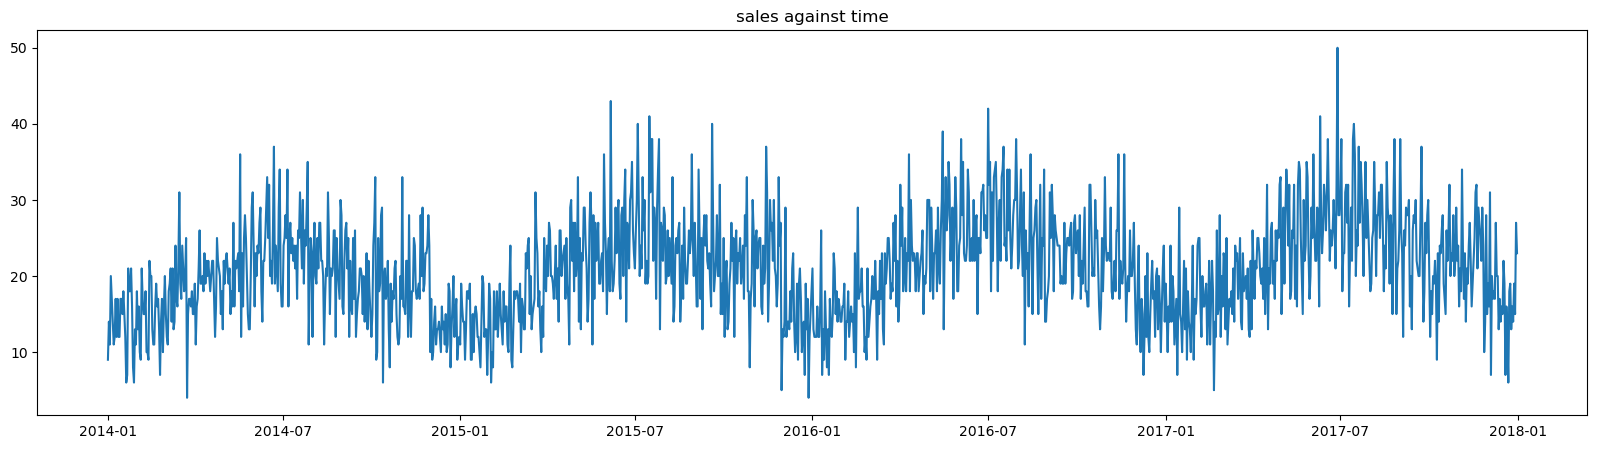

In [33]:
#plot df_target against index
plt.figure(figsize=(20, 5))
plt.plot(df.index, df[df_target], label=df_target)
plt.title(f"{df_target} against time")

Text(0.5, 1.0, 'sales distribution')

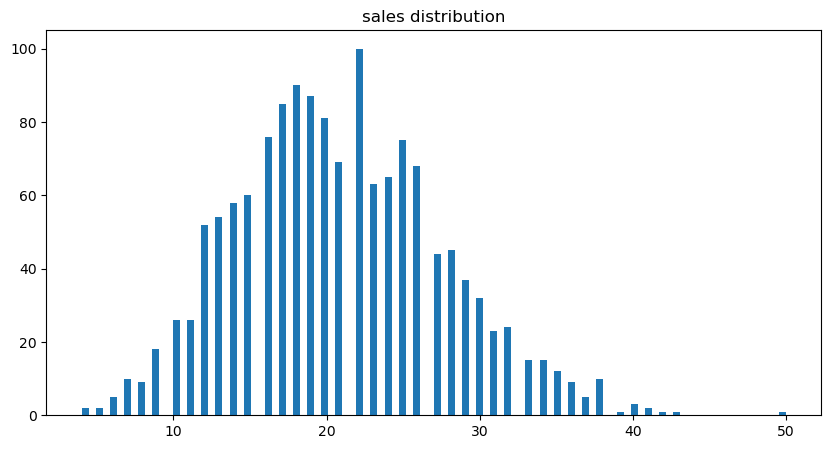

In [9]:
#plot df_target distribution
plt.figure(figsize=(10, 5))
plt.hist(df[df_target], bins=100)
plt.title(f"{df_target} distribution")

In [34]:
#unique values in the 'split' column
df['split'].unique()

array(['train', 'validation'], dtype=object)

In [41]:
# 1. Prepare the Data

#all other columns are predictors
y = df[df_target]
X = df.drop(columns=[df_target])

# 2. Split the Data into Training and Testing Sets
# It's crucial to split time series data chronologically to avoid data leakage

train_df = df[df["split"] == "train"]
test_df = df[df["split"] == "validation"]

X_train = train_df.drop(columns=[df_target, "split"])
y_train = train_df[df_target]

X_test = test_df.drop(columns=[df_target, "split"])
y_test = test_df[df_target]

# 3. Define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 4. Create XGB Regressor
xgb_base = xgb.XGBRegressor(random_state=42)

# Setup Randomized Search
xgbm = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,              # Number of parameter sets to try
    scoring='neg_root_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error', etc.
    cv=5,                   # Cross-validation folds
    verbose=1,
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

xgbm.fit(X_train, y_train)

# Function to wrap training process
def train_model():
    xgbm.fit(X_train, y_train)  
    return xgbm

# Measure time and memory
start_time = time.time()
mem_usage, model = memory_usage((train_model,), retval=True, max_usage=True)
end_time = time.time()

print(f"Time usage: {end_time - start_time:.2f} seconds")
print(f"Peak memory usage: {mem_usage:.2f} MB")


#print the best parameters
print("Best parameters found: ", xgbm.best_params_)

# Use the best trained model
model = xgbm.best_estimator_

# Merge X and y for easier indexing
df_full = X.copy()
df_full['target'] = y
df_full['split'] = df['split']  # make sure the 'split' column is included

# Filter only rows that are in train or validation (skip any test or unknown)
df_fw = df_full[df_full['split'].isin(['train', 'validation'])].copy()


# Drop split and date for modeling
features = df_fw.drop(columns=['target', 'split'])
target = df_fw['target'].values

predictions = []
actuals = []
horizon = 1  # One-step-ahead forecasting

for t in range(train_size, len(df_full) - horizon + 1):
    # Predict on the next time step
    X_test_t = features.iloc[t:t+horizon]
    y_test_t = target[t:t+horizon]

    y_pred = model.predict(X_test_t)

    predictions.extend(y_pred)
    actuals.extend(y_test_t)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Time usage: 8.44 seconds
Peak memory usage: 436.67 MB
Best parameters found:  {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


In [42]:
actuals = np.array(actuals)
predictions = np.array(predictions)

# 6. Evaluate the Model
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
adj_r2 = 1 - (1 - r2) * (len(actuals) - 1) / (len(actuals) - X_test.shape[1] - 1)
mape = np.mean(np.abs((actuals - predictions) / (actuals +1e-10))) * 100

print(f"Mean Absolute Error on the Test Set: {mae:.4f}")
print(f"Mean Squared Error on the Test Set: {mse:.4f}")
print(f"Root Mean Squared Error on the Test Set: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Adjusted R^2 Score: {adj_r2:.4f}")
print(f"Mean Absolute Percentage Error on the Test Set: {mape:.4f}%")

Mean Absolute Error on the Test Set: 3.2799
Mean Squared Error on the Test Set: 15.3736
Root Mean Squared Error on the Test Set: 3.9209
R^2 Score: 0.6549
Adjusted R^2 Score: 0.5920
Mean Absolute Percentage Error on the Test Set: 15.9519%


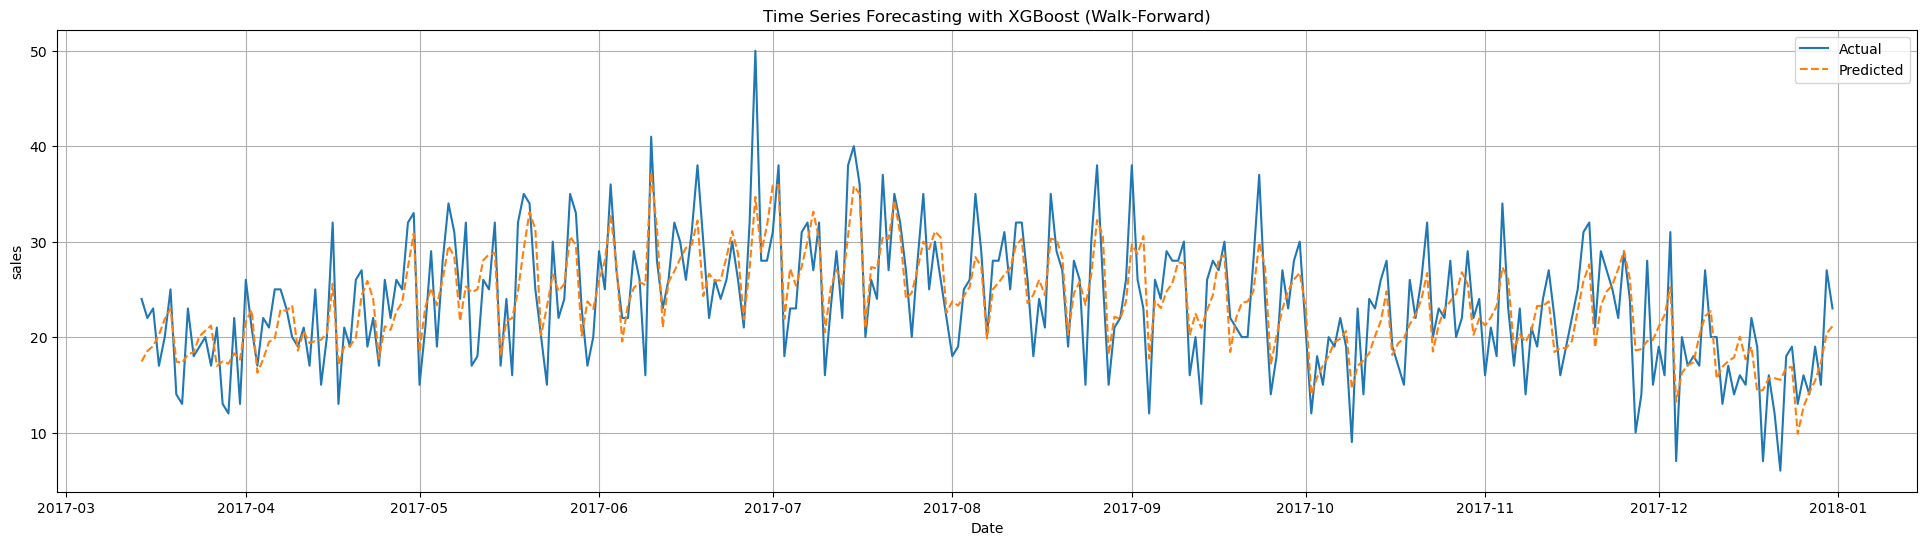

In [43]:
# Extract corresponding index for the walk-forward predictions
forecast_index = df.index[train_size:train_size + len(predictions)]

# Plot actual vs predicted
plt.figure(figsize=(24, 6))
plt.plot(forecast_index, actuals, label='Actual')
plt.plot(forecast_index, predictions, label='Predicted', linestyle='--')
plt.title('Time Series Forecasting with XGBoost (Walk-Forward)')
plt.xlabel('Date')
plt.ylabel(df_target)
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# 8. Feature importance
best_model = xgbm.best_estimator_
importances = best_model.feature_importances_

for feature, importance in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

sales_roll_median_28d: 0.4536
sales_roll_mean_7d: 0.1086
sales_roll_mean_14d: 0.1029
dayofweek: 0.0440
sales_lag_364: 0.0314
sales_lag_14: 0.0257
sales_roll_median_7d: 0.0243
sales_roll_max_7d: 0.0180
sales_roll_std_7d: 0.0154
sales_roll_min_7d: 0.0149
sales_lag_21: 0.0121
sales_lag_365: 0.0097
month: 0.0088
sales_roll_min_14d: 0.0083
dayofyear: 0.0076
sales_roll_median_14d: 0.0075
sales_roll_std_90d: 0.0073
sales_lag_1: 0.0069
sales_lag_7: 0.0068
sales_roll_mean_60d: 0.0066
sales_roll_std_14d: 0.0063
sales_roll_min_28d: 0.0062
weekofyear: 0.0060
sales_lag_180: 0.0059
sales_roll_max_90d: 0.0058
sales_roll_std_60d: 0.0055
sales_roll_mean_90d: 0.0054
quarter: 0.0052
sales_roll_mean_28d: 0.0050
sales_roll_std_28d: 0.0045
sales_lag_90: 0.0045
sales_lag_28: 0.0044
sales_lag_60: 0.0043
sales_roll_max_14d: 0.0035
sales_roll_min_60d: 0.0034
day: 0.0024
sales_lag_30: 0.0016
year: 0.0000
is_month_start: 0.0000
is_month_end: 0.0000
sales_roll_max_28d: 0.0000
sales_roll_median_60d: 0.0000
sales_ro

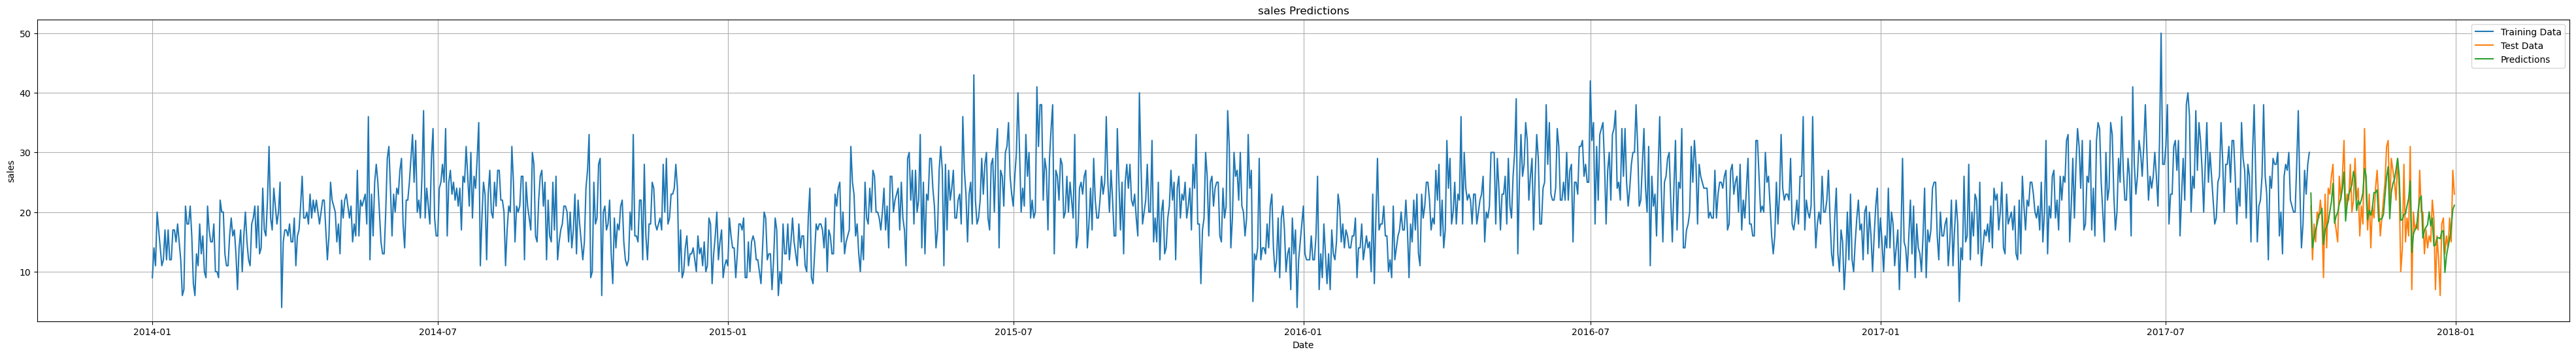

In [15]:
# 9. Plot the training data, test data and predictions on test set
plt.figure(figsize=(50, 6))
plt.plot(X_train.index, y_train, label='Training Data')
plt.plot(X_test.index, y_test, label='Test Data')
plt.plot(X_test.index, predictions, label='Predictions')
plt.title(f"{df_target} Predictions")
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

## TRANSPORT DATA

In [44]:
# load file 'Transport_Data/Baltimore_Lagged_Dataset.csv' into a pandas dataframe
df = pd.read_csv('Transport_Data/Baltimore_Lagged_Dataset.csv')


In [45]:
#df header
df.head()

Month  Total TEUs  Lag_1  Lag_2  Lag_3  Lag_6  Lag_12
0  1/1/99       38642  41957  43415  37762  41293   38104
1  2/1/99       39418  38642  41957  43415  36461   38175
2  3/1/99       45703  39418  38642  41957  41678   46578
3  4/1/99       40671  45703  39418  38642  37762   41703
4  5/1/99       39035  40671  45703  39418  43415   40908

In [46]:
df_target = 'Total TEUs'
df_predictors = [col for col in df.columns if col != df_target]

In [47]:
#set timestamp as index
df['Month'] = pd.to_datetime(df['Month'], format='%m/%d/%y')
df.set_index('Month', inplace=True)

Text(0.5, 1.0, 'Total TEUs against time')

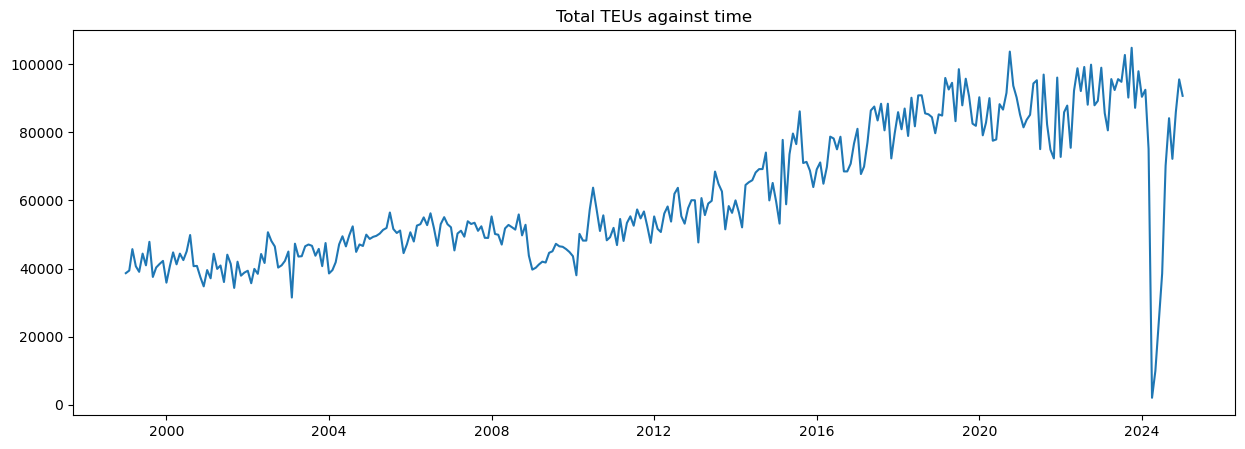

In [48]:
#plot df_target against index
plt.figure(figsize=(15, 5))
plt.plot(df.index, df[df_target], label=df_target)
plt.title(f"{df_target} against time")

Text(0.5, 1.0, 'Total TEUs distribution')

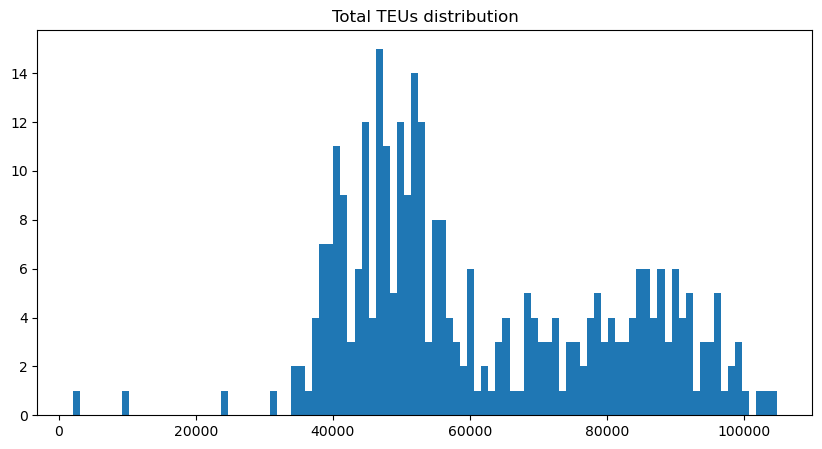

In [21]:
#plot df_target distribution
plt.figure(figsize=(10, 5))
plt.hist(df[df_target], bins=100)
plt.title(f"{df_target} distribution")

In [49]:
# 1. Prepare the Data

#all other columns are predictors
y = df[df_target]
X = df.drop(columns=[df_target])

# 2. Split the Data into Training and Testing Sets
# It's crucial to split time series data chronologically to avoid data leakage
train_size = int(len(df) * 0.8)  # Use 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 3. Define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 4. Create XGB Regressor
xgb_base = xgb.XGBRegressor(random_state=42)

# Setup Randomized Search
xgbm = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,              # Number of parameter sets to try
    scoring='neg_root_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error', etc.
    cv=5,                   # Cross-validation folds
    verbose=1,
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

xgbm.fit(X_train, y_train)

# Function to wrap training process
def train_model():
    xgbm.fit(X_train, y_train)  
    return xgbm

# Measure time and memory
start_time = time.time()
mem_usage, model = memory_usage((train_model,), retval=True, max_usage=True)
end_time = time.time()

print(f"Time usage: {end_time - start_time:.3f} seconds")
print(f"Peak memory usage: {mem_usage:.3f} MB")

#print the best parameters
print("Best parameters found: ", xgbm.best_params_)

# Use the best trained model
model = xgbm.best_estimator_

# Merge X and y for easier indexing
df_full = X.copy()
df_full['target'] = y

predictions = []
actuals = []
horizon = 1  # One-step-ahead forecasting

for t in range(train_size, len(df_full) - horizon + 1):
    # Predict on the next time step
    X_test_t = df_full.drop(columns='target').iloc[t:t+horizon]
    y_test_t = df_full['target'].iloc[t:t+horizon]

    y_pred = model.predict(X_test_t)

    predictions.extend(y_pred)
    actuals.extend(y_test_t.values)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Time usage: 2.759 seconds
Peak memory usage: 450.703 MB
Best parameters found:  {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [50]:
actuals = np.array(actuals)
predictions = np.array(predictions)

# 6. Evaluate the Model
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
adj_r2 = 1 - (1 - r2) * (len(actuals) - 1) / (len(actuals) - X_test.shape[1] - 1)
mape = np.mean(np.abs((actuals - predictions) / (actuals +1e-10))) * 100

print(f"Mean Absolute Error on the Test Set: {mae:.4f}")
print(f"Mean Squared Error on the Test Set: {mse:.4f}")
print(f"Root Mean Squared Error on the Test Set: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Adjusted R^2 Score: {adj_r2:.4f}")
print(f"Mean Absolute Percentage Error on the Test Set: {mape:.4f}%")

Mean Absolute Error on the Test Set: 10674.8814
Mean Squared Error on the Test Set: 274188797.6521
Root Mean Squared Error on the Test Set: 16558.6472
R^2 Score: 0.2479
Adjusted R^2 Score: 0.1819
Mean Absolute Percentage Error on the Test Set: 85.1123%


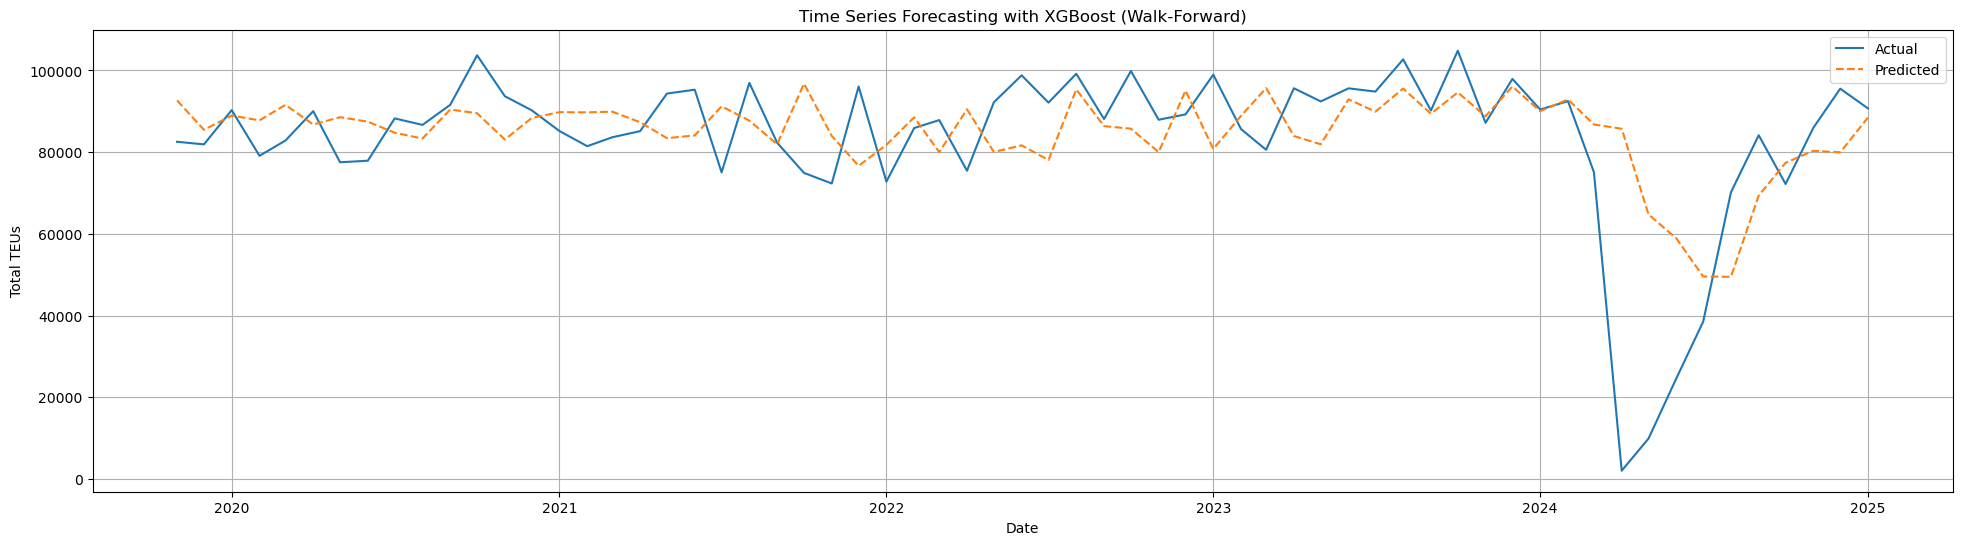

In [51]:
# Extract corresponding index for the walk-forward predictions
forecast_index = df.index[train_size:train_size + len(predictions)]

# Plot actual vs predicted
plt.figure(figsize=(24, 6))
plt.plot(forecast_index, actuals, label='Actual')
plt.plot(forecast_index, predictions, label='Predicted', linestyle='--')
plt.title('Time Series Forecasting with XGBoost (Walk-Forward)')
plt.xlabel('Date')
plt.ylabel(df_target)
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# 8. Feature importance
best_model = xgbm.best_estimator_
importances = best_model.feature_importances_

for feature, importance in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

Lag_1: 0.4463
Lag_2: 0.1941
Lag_3: 0.1888
Lag_12: 0.1280
Lag_6: 0.0429


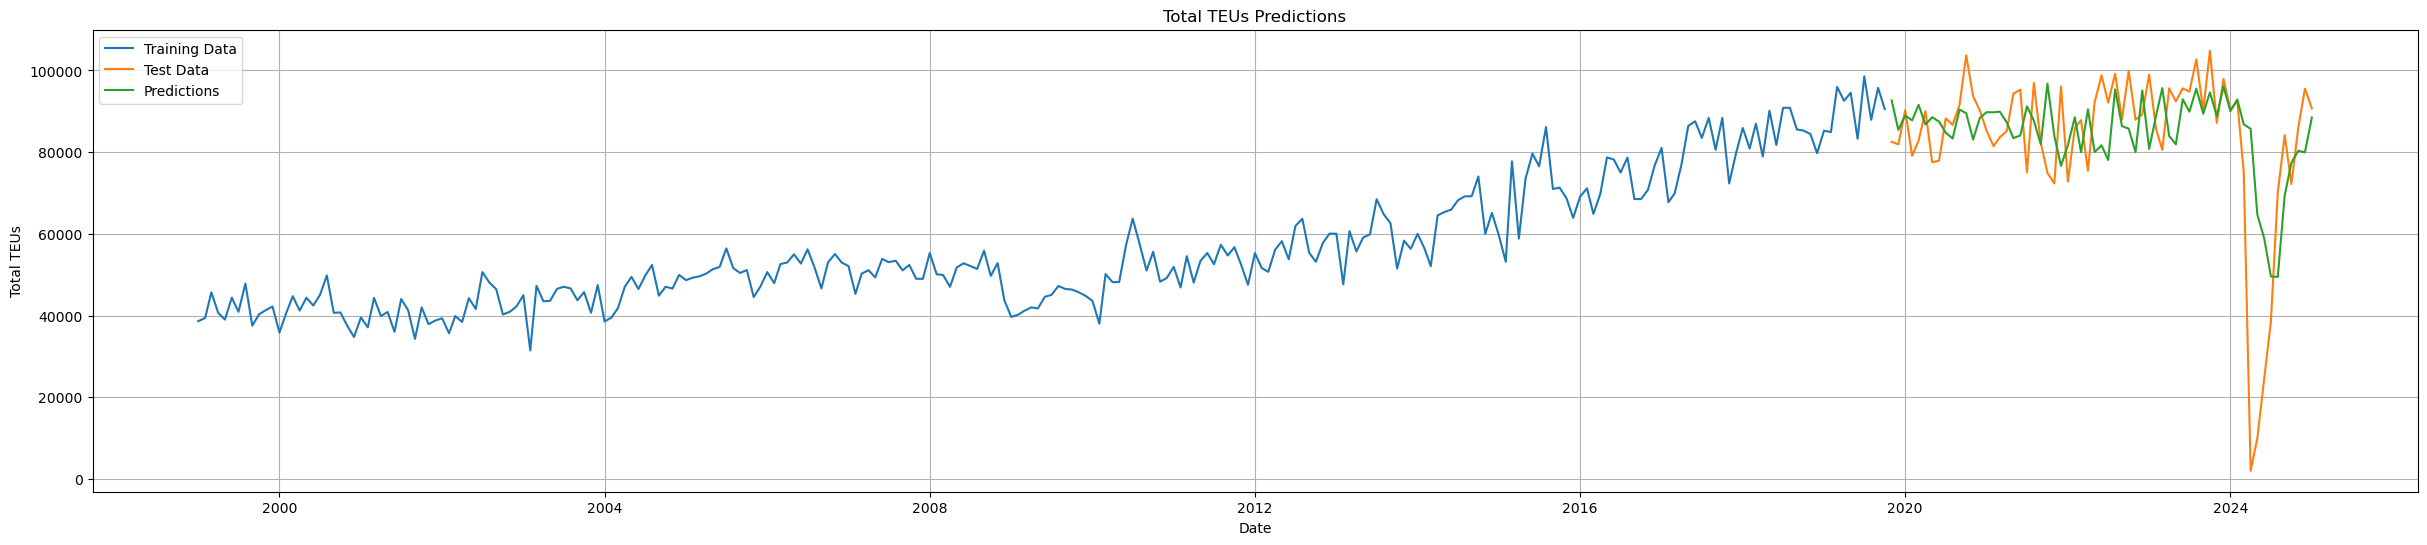

In [26]:
# 9. Plot the training data, test data and predictions on test set
plt.figure(figsize=(30, 6))
plt.plot(df.index[:train_size], y_train, label='Training Data')
plt.plot(df.index[train_size:], y_test, label='Test Data')
plt.plot(df.index[train_size:], predictions, label='Predictions')
plt.title(f"{df_target} Predictions")
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()